In [2]:
!pip install rouge_score
!pip install datasets
!pip install transformers
!pip install matplotlib
!pip install sentencepiece
!pip install "protobuf<3.21"
!pip install sacrebleu


In [3]:
import torch
from datasets import load_dataset, load_metric
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset

import warnings
warnings.filterwarnings('ignore')

In [4]:
train_dataset = pd.read_csv("cnn_dailymail/train.csv")
val_dataset = pd.read_csv("cnn_dailymail/validation.csv")

In [5]:
def plot_article_length_histogram(dataset, bins=100):
    article_lengths = [len(doc.split()) for doc in dataset["article"]]
    plt.figure(figsize=(10, 5))
    plt.hist(article_lengths, bins=bins)
    plt.title("Article Length Histogram")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.show()

In [6]:
def plot_highlights_length_histogram(dataset, bins=100):
    highlights_lengths = [len(doc.split()) for doc in dataset["highlights"]]
    plt.figure(figsize=(10, 5))
    plt.hist(highlights_lengths, bins=bins)
    plt.title("Highlights Length Histogram")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.show()

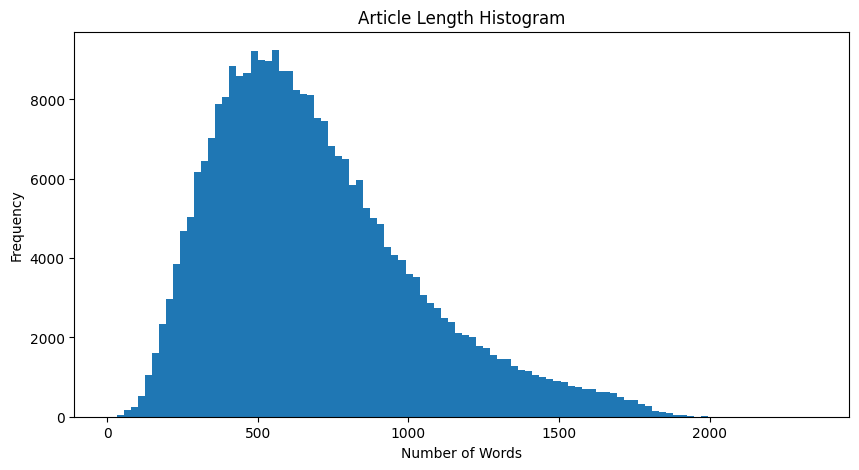

In [7]:
#Article Length visualization
plot_article_length_histogram(train_dataset)

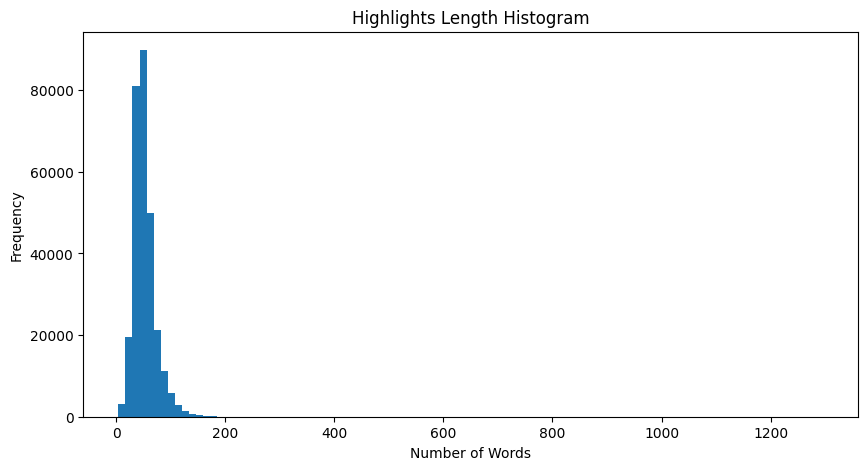

In [8]:
#Highlights Length visualization
plot_highlights_length_histogram(train_dataset)

In [9]:
# Convert the DataFrame to a Hugging Face Dataset object
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)

In [10]:
train_dataset = train_dataset.select(range(30000))
val_dataset = val_dataset.select(range(1500))

In [11]:
def check_type(example):
    return {"article_type": str(type(example["article"])), "highlights_type": str(type(example["highlights"]))}

type_check_results = val_dataset.map(check_type, remove_columns=train_dataset.column_names)
type_check_results = pd.DataFrame(type_check_results)
print(type_check_results["article_type"].value_counts())
print(type_check_results["highlights_type"].value_counts())


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

article_type
<class 'str'>    1500
Name: count, dtype: int64
highlights_type
<class 'str'>    1500
Name: count, dtype: int64


In [12]:
#Model and tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [13]:
#preprocessing
def preprocess_function(examples, tokenizer, max_input_length, max_target_length):
    inputs = [f"summarize: {doc}" for doc in examples["article"]]
    targets = examples["highlights"]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")
    model_targets = tokenizer(targets, max_length=max_target_length, truncation=True, padding="max_length")
    model_inputs["labels"] = model_targets["input_ids"]
    return model_inputs

In [14]:
max_input_length = 256
max_target_length = 50
tokenized_train_dataset = train_dataset.map(
    preprocess_function,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_input_length": max_input_length,
        "max_target_length": max_target_length,
    },
    batched=True,
)
tokenized_val_dataset = val_dataset.map(
    preprocess_function,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_input_length": max_input_length,
        "max_target_length": max_target_length,
    },
    batched=True,
)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [15]:
#Training arguments and data collator
training_args = Seq2SeqTrainingArguments(
    output_dir="output",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    save_total_limit=3,
    fp16=True,
    load_best_model_at_end=True,
    report_to=[]
)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [19]:
# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.174200,1.884959
2,2.145600,1.874168


In [21]:
# Evaluate
eval_results = trainer.evaluate()

# Print evaluation results
print("\nEvaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")


Evaluation Results:
eval_loss: 1.8702
eval_runtime: 3.7801
eval_samples_per_second: 396.8110
eval_steps_per_second: 49.7340
epoch: 3.0000
